## **ITEC623 - Deep Learning Project: Cat Face Detection with YOLOv8**
# **Saisravani Dharmavarapu - s00389303**


In [1]:
# ============================================================================
# STEP 1: Activate GPU in Google Colab
# ============================================================================
# Runtime -> Change runtime type -> Hardware accelerator -> GPU -> Save

# Display all Configurations of Hardware activated

import torch
print("="*60)
print("GPU CONFIGURATION")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: GPU not available. Please enable GPU in Runtime settings.")
print("="*60 + "\n")

GPU CONFIGURATION
PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4
GPU Memory: 14.74 GB



In [2]:
# ============================================================================
# STEP 2: Install Required Packages (Modern YOLO Implementation)
# ============================================================================
# Using Ultralytics YOLOv8 - the latest and most maintained YOLO version


print("\n" + "="*60)
print("INSTALLING REQUIRED PACKAGES")
print("="*60)

!pip install -q ultralytics pandas pillow matplotlib opencv-python

# Verify installation
from ultralytics import YOLO
print("✓ Ultralytics YOLOv8 installed successfully")
print(f"✓ Ultralytics version: {YOLO.__module__}")




INSTALLING REQUIRED PACKAGES
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Ultralytics YOLOv8 installed successfully
✓ Ultralytics version: ultralytics.models.yolo.model


In [3]:
# ============================================================================
# STEP 3: Import Required Libraries
# ============================================================================

import os
import shutil
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import files
import zipfile

print("\n✓ All libraries imported successfully\n")


✓ All libraries imported successfully



In [4]:
# ============================================================================
# STEP 4: Upload Required Files
# ============================================================================

# Uploading all 3 files provided

print("="*60)
print("FILE UPLOAD")
print("="*60)
print("\nUploading these 3 files:")
print("1. Training_Images.zip")
print("2. Test_Images.zip")
print("3. Training_Images_labels.csv")

FILE UPLOAD

Uploading these 3 files:
1. Training_Images.zip
2. Test_Images.zip
3. Training_Images_labels.csv


In [5]:
# ============================================================================
# STEP 5: Extract and Organize Dataset
# ============================================================================

# Placing the extracted data into a folder named cat_face_dataset

print("="*60)
print("EXTRACTING AND ORGANIZING DATASET")
print("="*60)

# Create directory structure for YOLO format
dataset_root = Path('cat_face_dataset')
for subdir in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    (dataset_root / subdir).mkdir(parents=True, exist_ok=True)

# Extract training images
print("\nExtracting Training_Images.zip...")
with zipfile.ZipFile('/content/Training_Images kaggle.zip', 'r') as zip_ref:
    zip_ref.extractall('train_images_temp')
print("✓ Training images extracted")

# Extract test images
print("Extracting Test_Images.zip...")
with zipfile.ZipFile('/content/Test_Images.zip', 'r') as zip_ref:
    zip_ref.extractall('test_images')
print("✓ Test images extracted")

# Read the CSV labels with proper data types
df_labels = pd.read_csv('/content/Training_Images_labels kaggle.csv',
                        names=['image', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])

# Convert coordinate columns to numeric (handle any string values)
for col in ['xmin', 'ymin', 'xmax', 'ymax']:
    df_labels[col] = pd.to_numeric(df_labels[col], errors='coerce')

# Remove any rows with NaN values
df_labels = df_labels.dropna()

print(f"\n✓ Dataset Information:")
print(f"  - Total training images: {len(df_labels)}")
print(f"  - Unique images: {df_labels['image'].nunique()}")
print(f"  - Labels: {df_labels['label'].unique()}")
print(f"\nFirst few entries:")
print(df_labels.head(10))
print(f"\nData types:")
print(df_labels.dtypes)


EXTRACTING AND ORGANIZING DATASET

Extracting Training_Images.zip...
✓ Training images extracted
Extracting Test_Images.zip...
✓ Test images extracted

✓ Dataset Information:
  - Total training images: 124
  - Unique images: 100
  - Labels: ['Cat_Face']

First few entries:
    image        xmin       ymin        xmax        ymax     label
1   0.jpg   79.574329   3.017903  215.089195  143.721290  Cat_Face
2   1.jpg   59.437106   6.045714  174.326662  126.434286  Cat_Face
3   2.jpg   26.523568  15.133689  106.929659   87.180228  Cat_Face
4   3.jpg   86.635511   2.300571  196.617330  124.230857  Cat_Face
5   4.jpg    3.457861   0.886857  106.126525  103.318857  Cat_Face
6   5.jpg   95.651922  29.751827  150.578680   79.453498  Cat_Face
7   6.jpg  135.097897   4.324219  265.692531  130.574219  Cat_Face
8   7.jpg   65.828571  48.857143  177.171429  152.742857  Cat_Face
9   8.jpg  145.258685  54.571429  212.950993  129.225143  Cat_Face
10  9.jpg   80.658448  39.452903  179.530094  137.417903

In [6]:
# ============================================================================
# STEP 6: Convert to YOLO Format
# ============================================================================

print("\n" + "="*60)
print("CONVERTING TO YOLO FORMAT")
print("="*60)

def convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    """
    Convert bounding box from (xmin, ymin, xmax, ymax) to YOLO format
    YOLO format: (x_center, y_center, width, height) - all normalized to [0, 1]
    """
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    # Clip values to [0, 1] range
    x_center = np.clip(x_center, 0, 1)
    y_center = np.clip(y_center, 0, 1)
    width = np.clip(width, 0, 1)
    height = np.clip(height, 0, 1)

    return x_center, y_center, width, height

# Find all training image files
train_img_folder = 'train_images_temp'
all_img_files = []
for root, dirs, files in os.walk(train_img_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_img_files.append(os.path.join(root, file))

# Create a mapping of image names to full paths
img_name_to_path = {}
for img_path in all_img_files:
    img_name = os.path.basename(img_path)
    img_name_to_path[img_name] = img_path

# Split dataset: 80% train, 20% validation
train_split_ratio = 0.8
unique_images = df_labels['image'].unique()
np.random.seed(42)
np.random.shuffle(unique_images)
split_idx = int(len(unique_images) * train_split_ratio)
train_images = set(unique_images[:split_idx])
val_images = set(unique_images[split_idx:])

print(f"\nDataset split:")
print(f"  - Training: {len(train_images)} images")
print(f"  - Validation: {len(val_images)} images")

# Process each image
processed_count = 0
skipped_count = 0

for img_name in unique_images:
    if img_name not in img_name_to_path:
        print(f"Warning: Image {img_name} not found in extracted files")
        skipped_count += 1
        continue

    img_path = img_name_to_path[img_name]

    # Get image dimensions
    try:
        with Image.open(img_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"Error reading {img_name}: {e}")
        skipped_count += 1
        continue

    # Determine split
    split = 'train' if img_name in train_images else 'val'

    # Copy image to appropriate folder
    dest_img_path = dataset_root / 'images' / split / img_name
    shutil.copy(img_path, dest_img_path)

    # Get all bounding boxes for this image
    img_boxes = df_labels[df_labels['image'] == img_name]

    # Create YOLO format label file
    label_filename = img_name.rsplit('.', 1)[0] + '.txt'
    label_path = dataset_root / 'labels' / split / label_filename

    with open(label_path, 'w') as f:
        for _, row in img_boxes.iterrows():
            x_center, y_center, width, height = convert_bbox_to_yolo(
                row['xmin'], row['ymin'], row['xmax'], row['ymax'],
                img_width, img_height
            )
            # Class 0 for Cat_Face
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    processed_count += 1

print(f"\n✓ Conversion complete:")
print(f"  - Processed: {processed_count} images")
print(f"  - Skipped: {skipped_count} images")
print(f"  - Training images: {len(list((dataset_root / 'images' / 'train').glob('*')))}")
print(f"  - Validation images: {len(list((dataset_root / 'images' / 'val').glob('*')))}")


CONVERTING TO YOLO FORMAT

Dataset split:
  - Training: 80 images
  - Validation: 20 images

✓ Conversion complete:
  - Processed: 100 images
  - Skipped: 0 images
  - Training images: 80
  - Validation images: 20


In [7]:
# ============================================================================
# STEP 7: Create YOLO Dataset Configuration
# ============================================================================

dataset_config = {
    'path': str(dataset_root.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'names': {
        0: 'Cat_Face'
    }
}

config_path = dataset_root / 'data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print(f"\n✓ Dataset configuration saved to: {config_path}")


✓ Dataset configuration saved to: cat_face_dataset/data.yaml


In [8]:
# ============================================================================
# STEP 8: Train YOLOv8 Model
# ============================================================================

print("\n" + "="*60)
print("TRAINING YOLOV8 MODEL")
print("="*60)

# Initialize YOLOv8 model
# Options: yolov8n.pt (nano - fastest), yolov8s.pt (small), yolov8m.pt (medium)
model = YOLO('yolov8n.pt')

print("\n🚀 Starting training...")
print("This may take 10-30 minutes depending on your dataset size and epochs\n")

# Train the model
results = model.train(
    data=str(config_path),
    epochs=50,                  # Number of training epochs
    imgsz=640,                  # Image size
    batch=16,                   # Batch size (reduce if out of memory)
    device=0,                   # GPU device
    project='runs/train',
    name='cat_face_detection',
    patience=15,                # Early stopping (if no change in accuracy)
    save=True,
    plots=True,
    verbose=True
)

print("\n✓ Training completed!")
print(f"✓ Model saved to: runs/train/cat_face_detection/weights/best.pt")


TRAINING YOLOV8 MODEL

🚀 Starting training...
This may take 10-30 minutes depending on your dataset size and epochs

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cat_face_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cat_face_detection, nbs=6


TRAINING RESULTS & METRICS

📊 Training Curves:


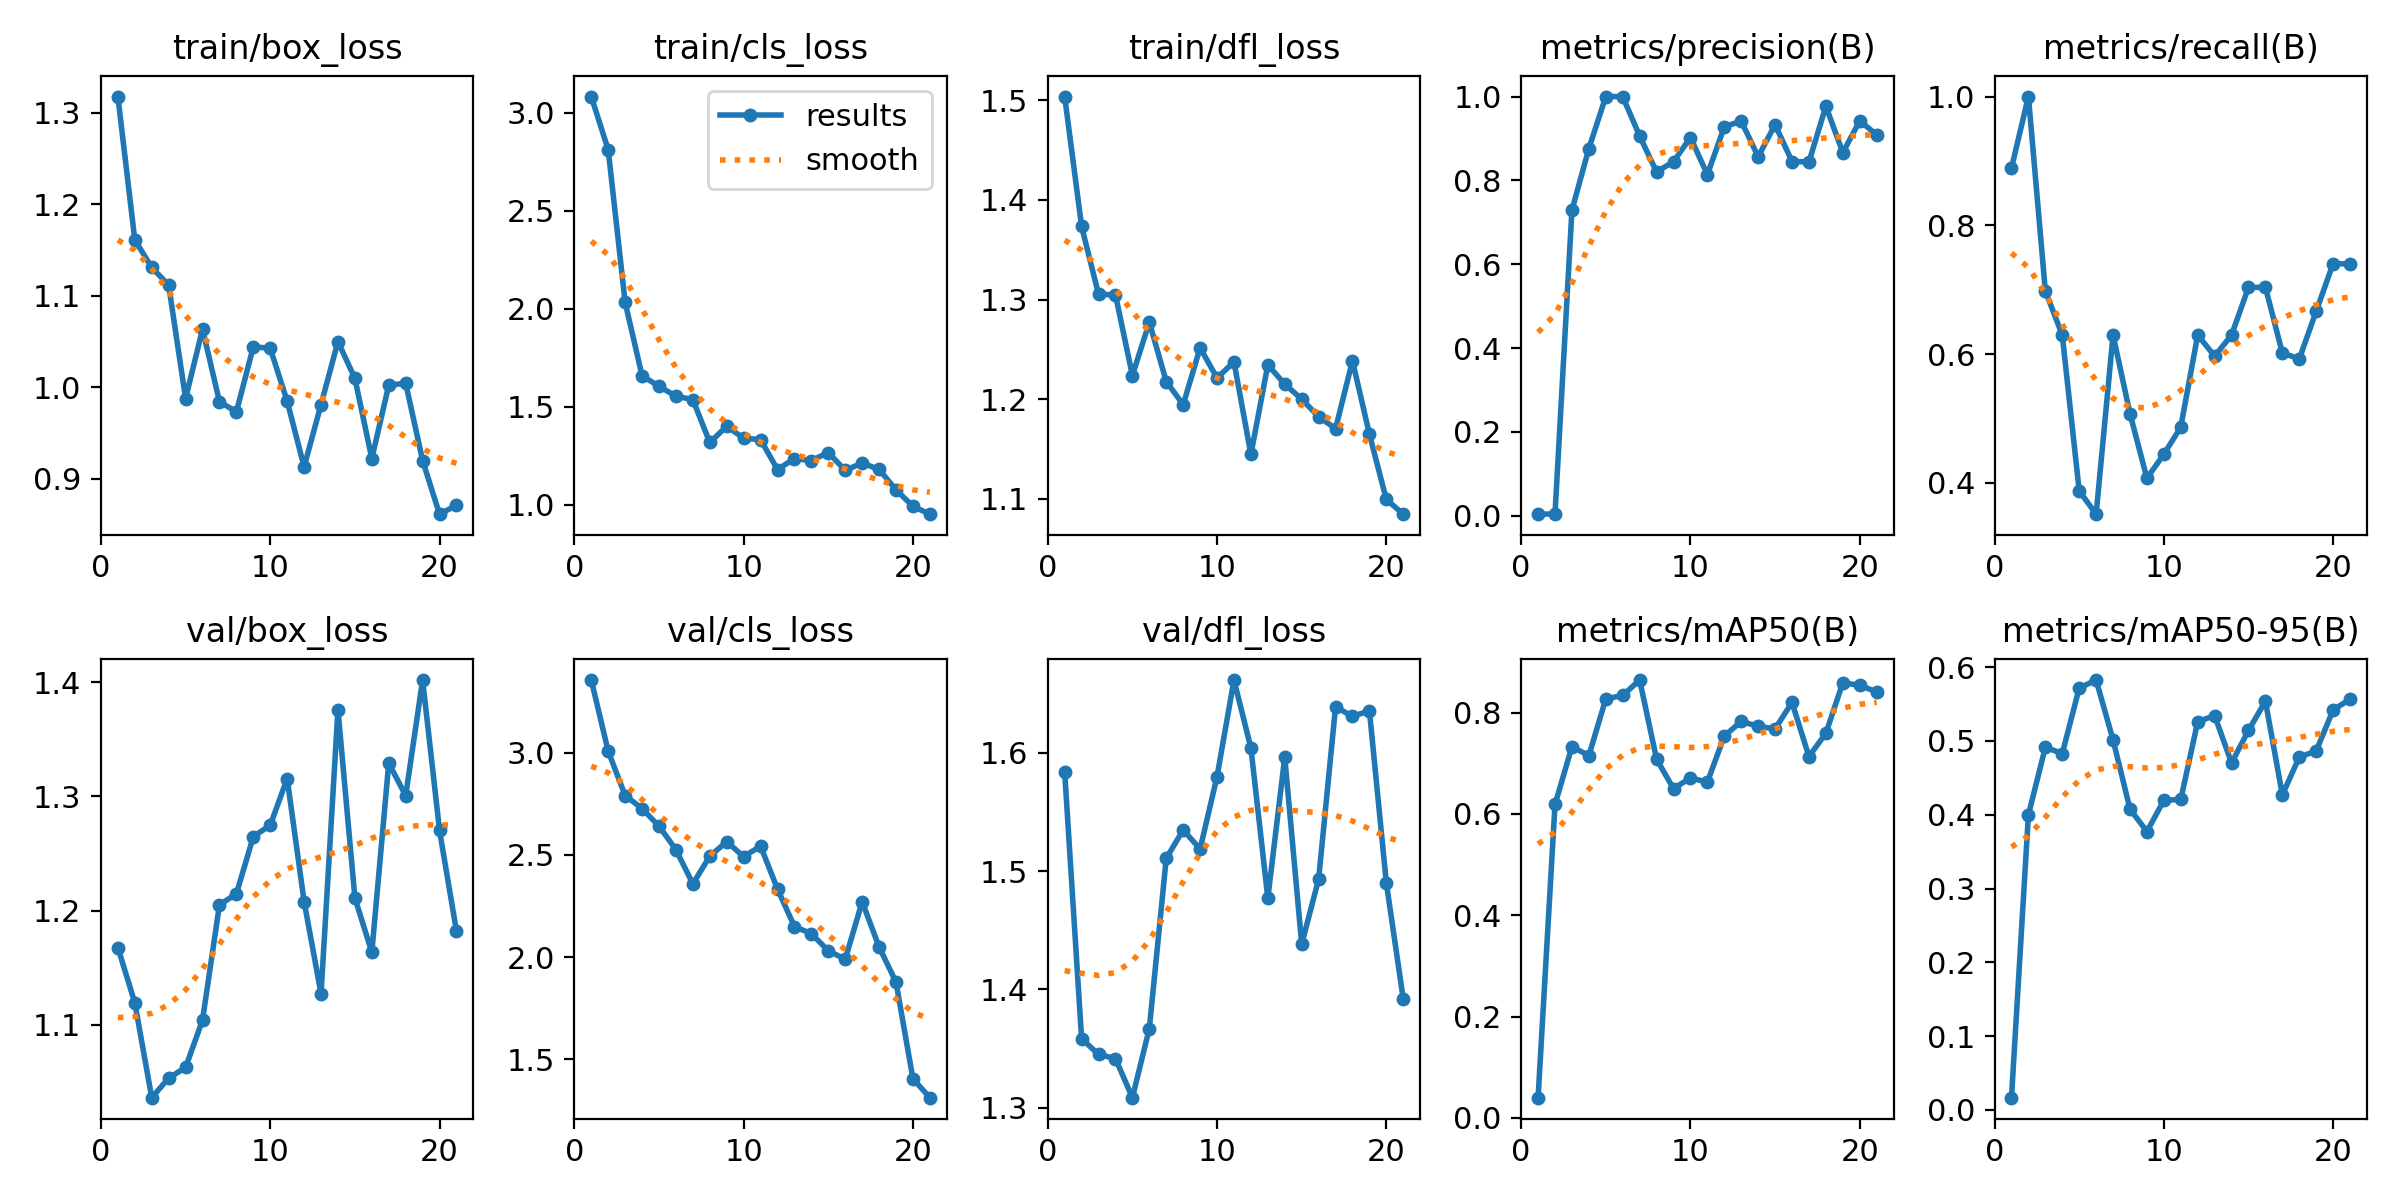


📊 Confusion Matrix:


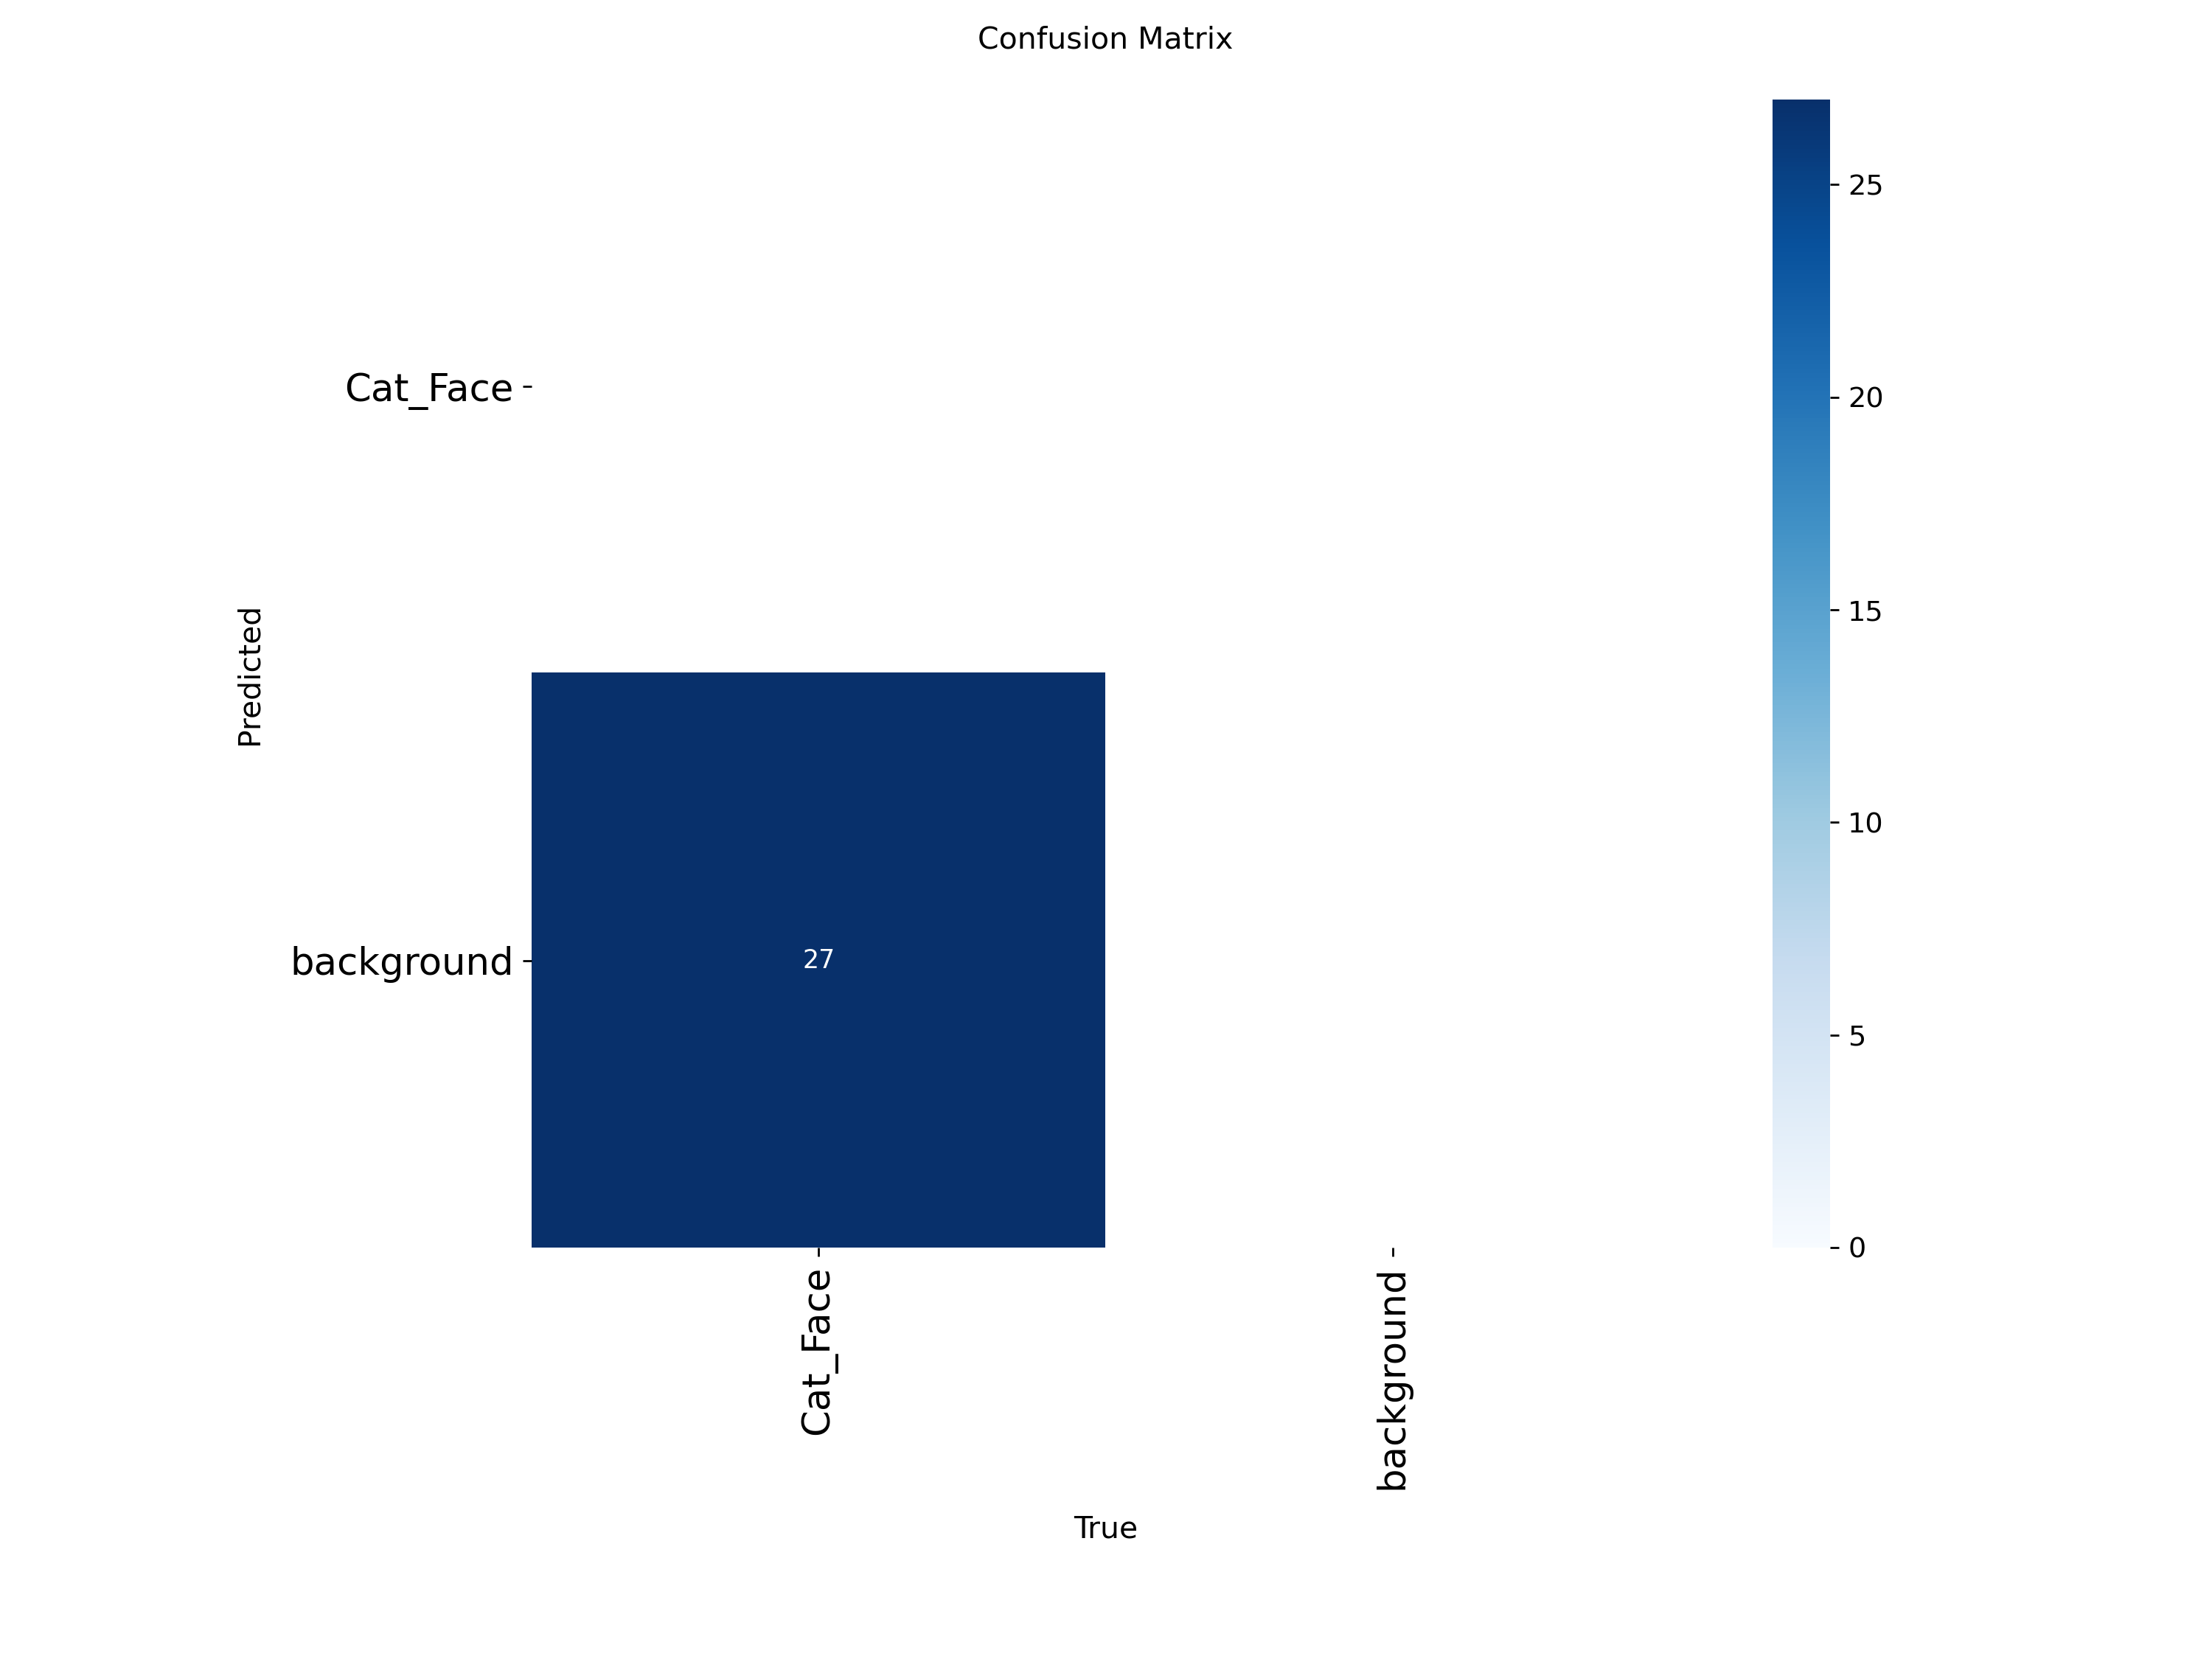


📊 Sample Training Batch:


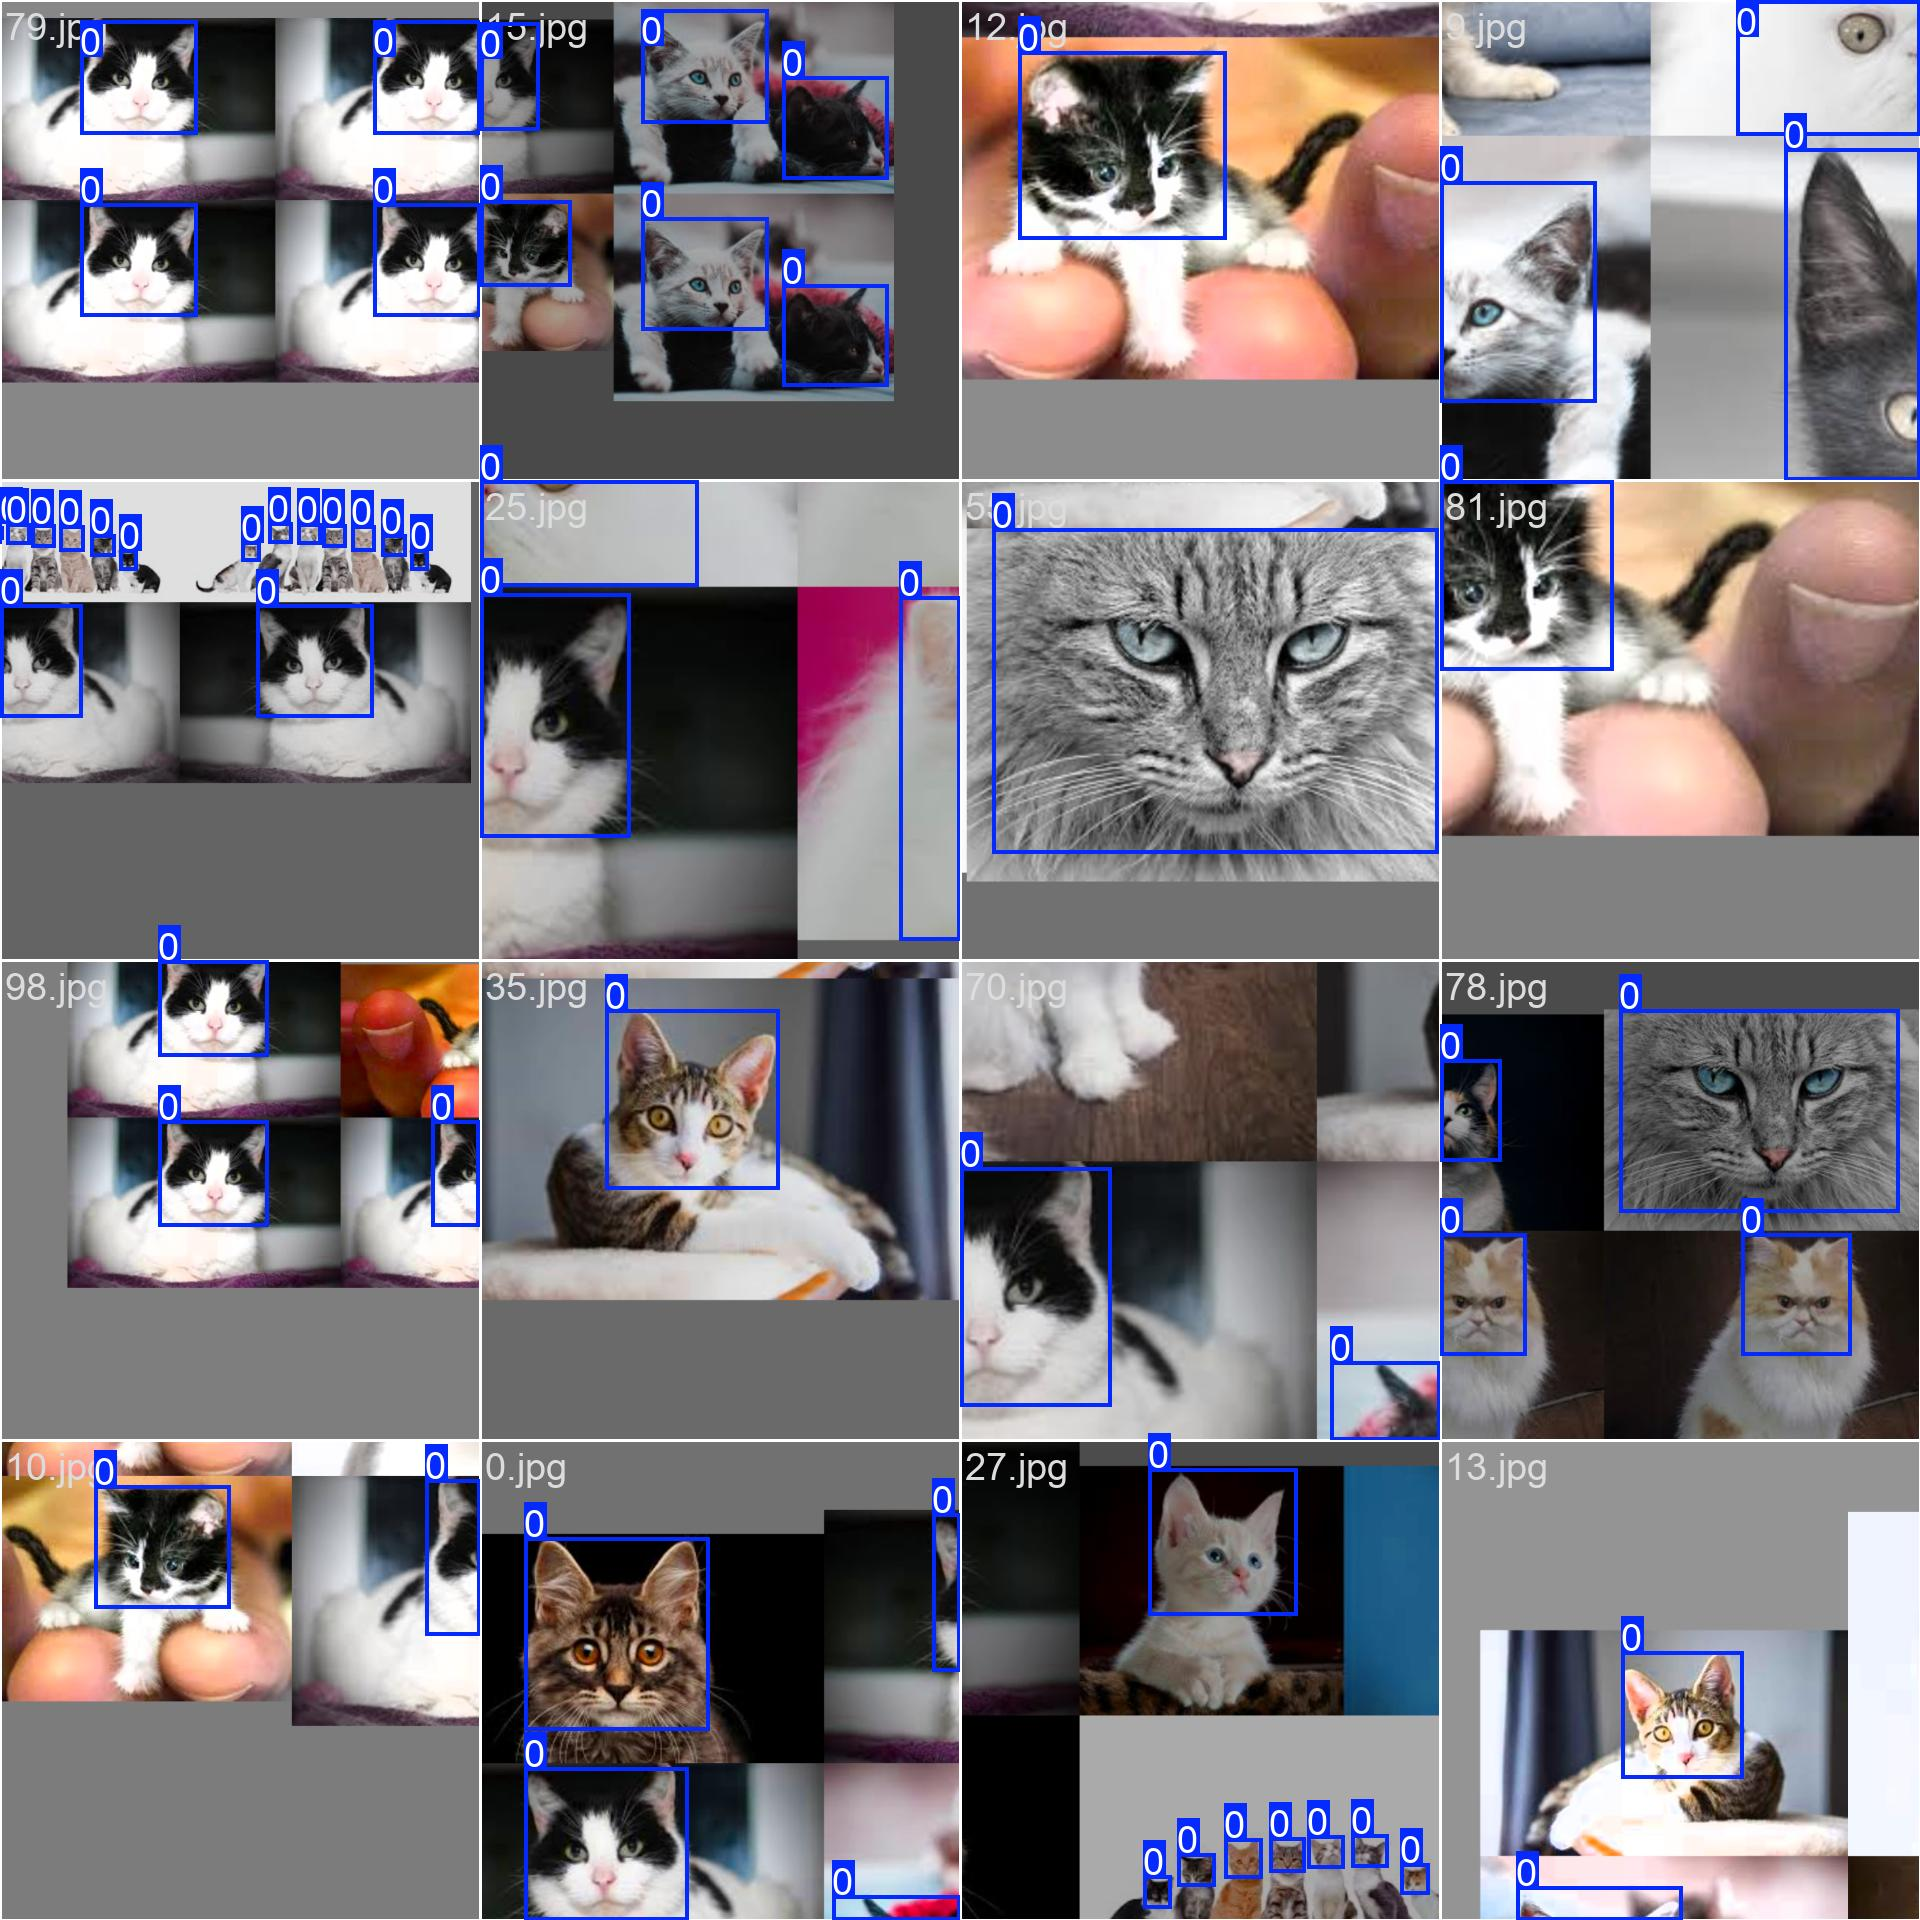


📊 Validation Predictions:


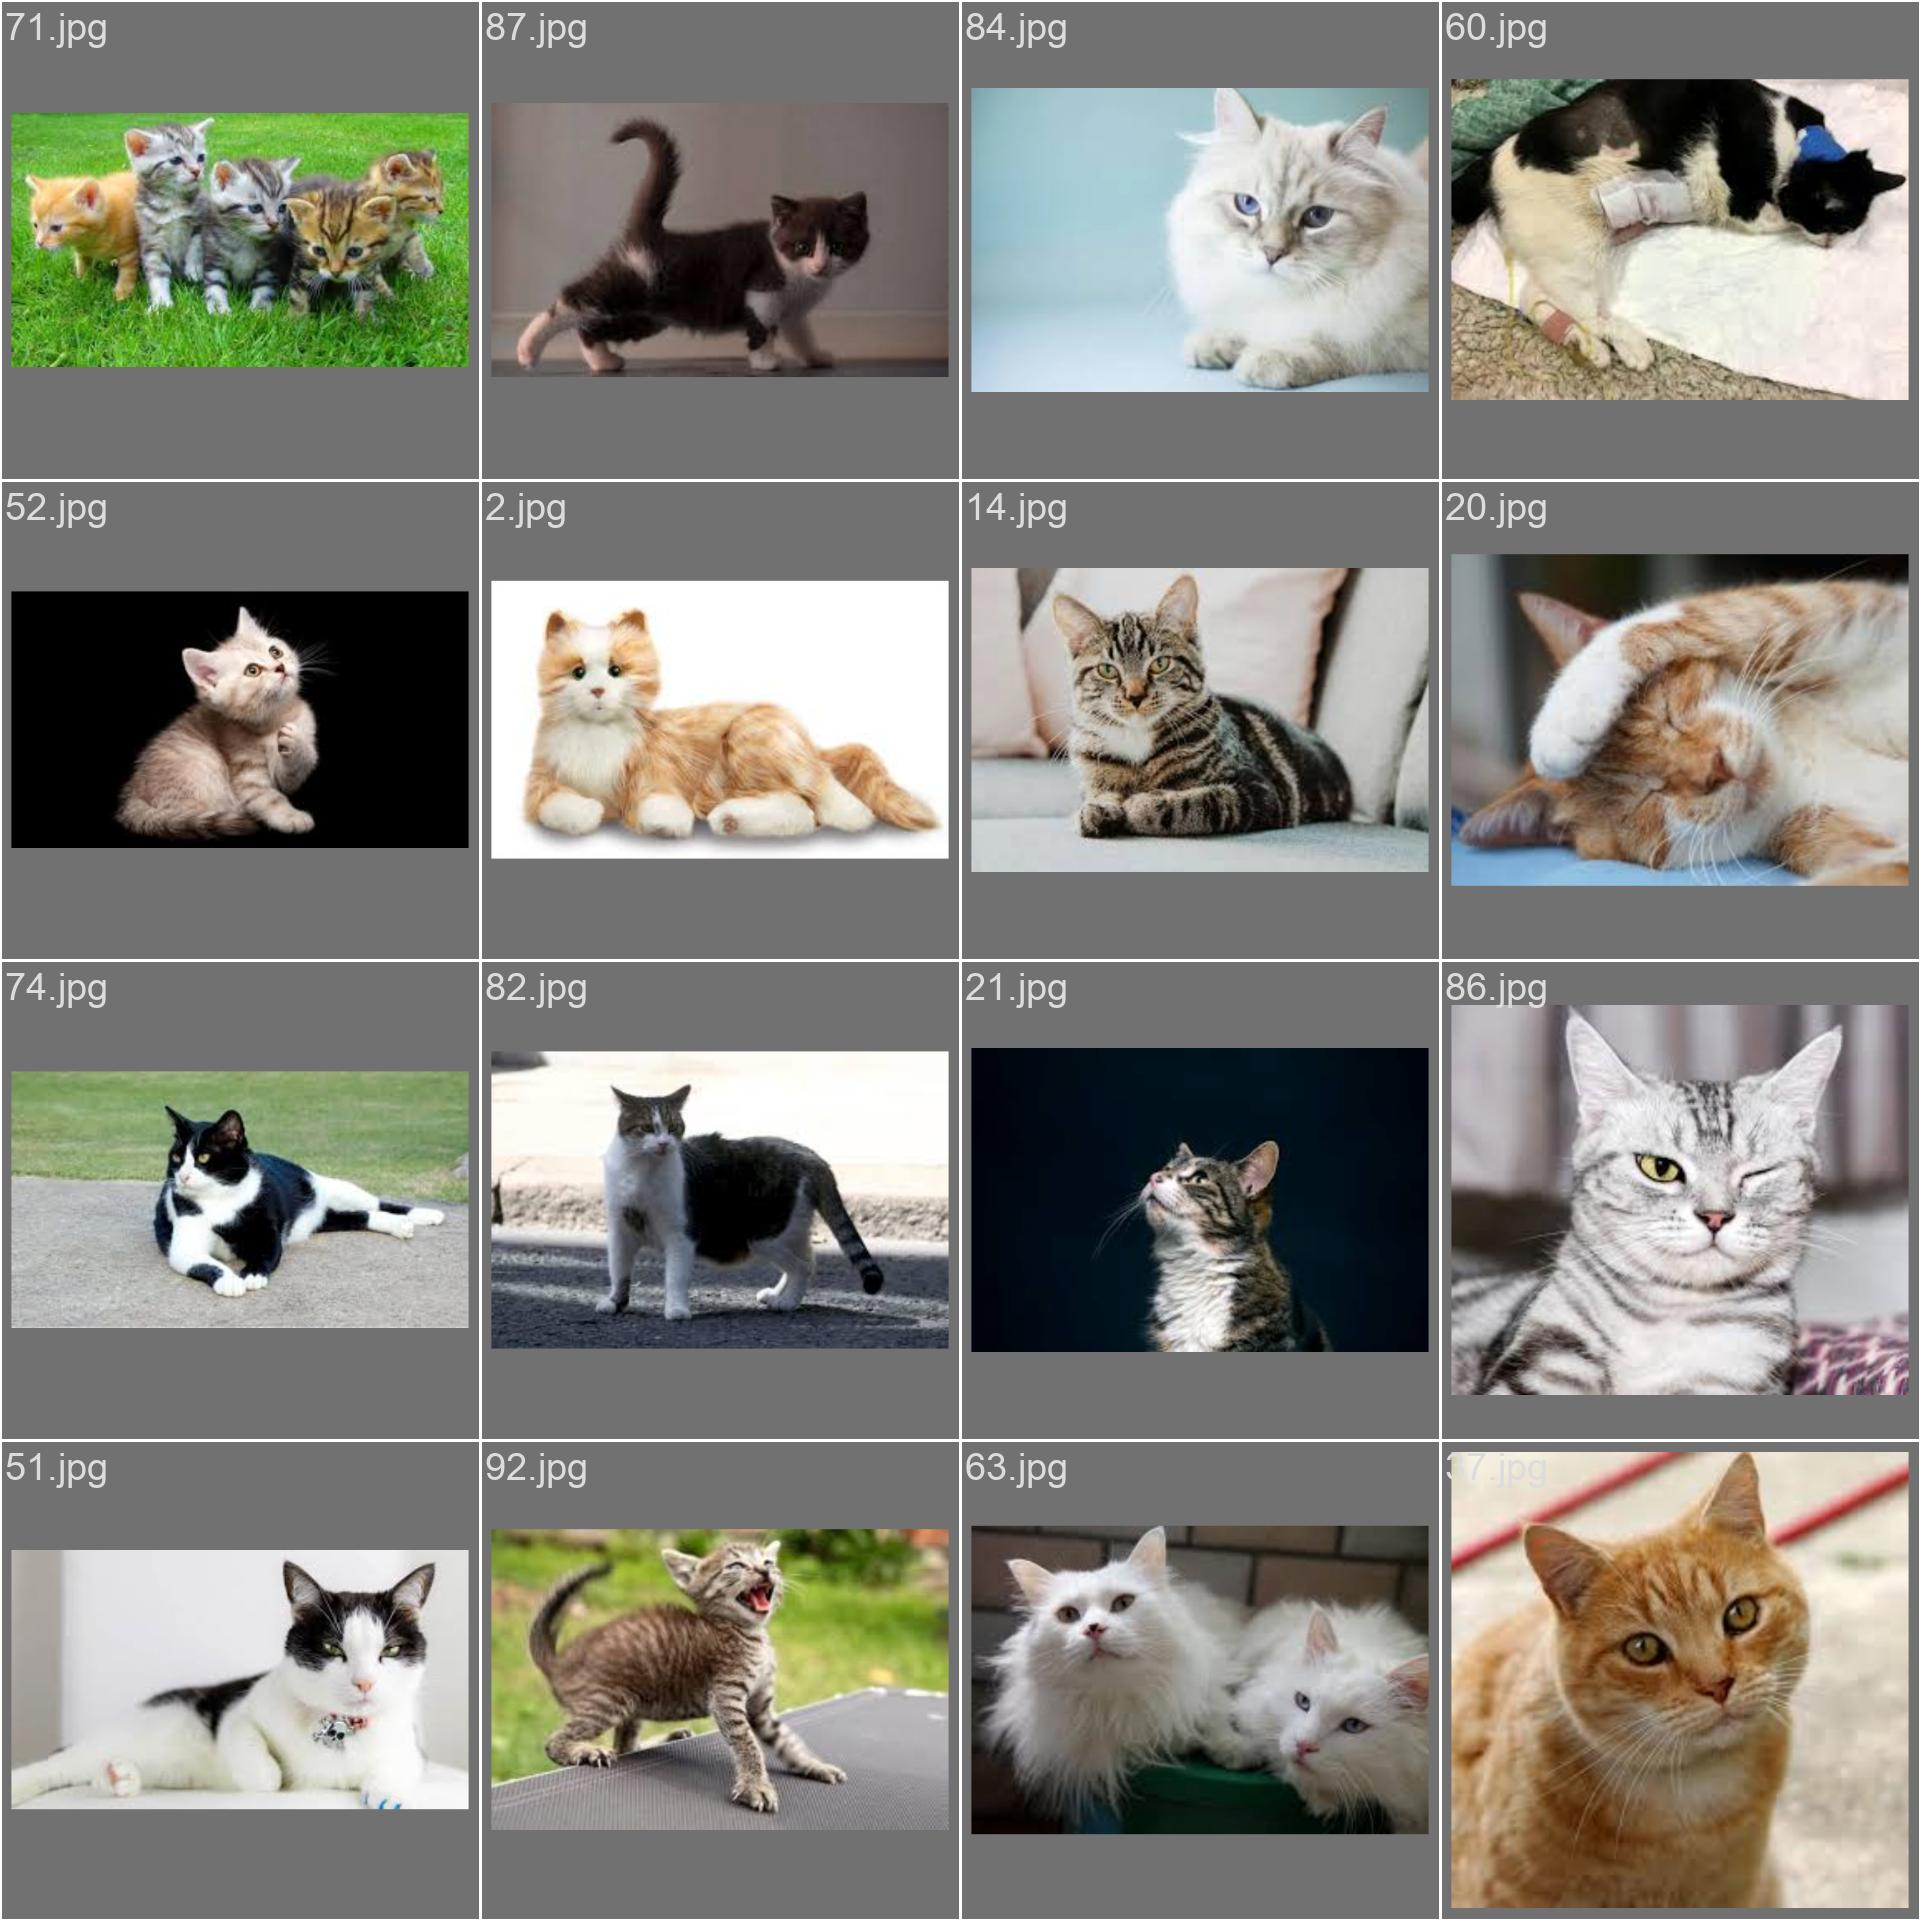

In [9]:
# ============================================================================
# STEP 9: Visualize Training Results
# ============================================================================

# Ultralytics preloads all metrics with PYTORCGH, so we CANNOT USE TENSORBOARD
# Displaying training images with bounding boxes and metrics evaluations

print("\n" + "="*60)
print("TRAINING RESULTS & METRICS")
print("="*60)

from IPython.display import Image as IPImage, display

results_path = Path('runs/train/cat_face_detection')

# Display results
print("\n📊 Training Curves:")
if (results_path / 'results.png').exists():
    display(IPImage(filename=str(results_path / 'results.png')))

print("\n📊 Confusion Matrix:")
if (results_path / 'confusion_matrix.png').exists():
    display(IPImage(filename=str(results_path / 'confusion_matrix.png')))

print("\n📊 Sample Training Batch:")
if (results_path / 'train_batch0.jpg').exists():
    display(IPImage(filename=str(results_path / 'train_batch0.jpg')))

print("\n📊 Validation Predictions:")
if (results_path / 'val_batch0_pred.jpg').exists():
    display(IPImage(filename=str(results_path / 'val_batch0_pred.jpg')))






In [10]:
# ============================================================================
# STEP 10: Run Inference on Test Images
# ============================================================================

# Predicting on test images using trained YOLOv8 model

print("\n" + "="*60)
print("RUNNING INFERENCE ON TEST SET")
print("="*60)

# Load the best trained model
best_model_path = 'runs/train/cat_face_detection/weights/best.pt'
trained_model = YOLO(best_model_path)

print(f"\n✓ Loaded best model from: {best_model_path}")

# Find test images
test_img_folder = '/content/test_images/Test_Images'
test_images = []
for root, dirs, files in os.walk(test_img_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_images.append(os.path.join(root, file))

print(f"✓ Found {len(test_images)} test images")
if len(test_images) > 0:
    # Get the actual folder containing images
    first_img_folder = os.path.dirname(test_images[0])
    if first_img_folder != test_img_folder:
        test_img_folder = first_img_folder
        print(f"✓ Test images located in: {test_img_folder}")

# Run inference with LOWER confidence threshold
print("\n🔍 Running inference...")
predictions = trained_model.predict(
    source=test_images,
    conf=0.02,            # Very low confidence threshold to catch all detections
    iou=0.04,             # NMS IOU threshold
    max_det=5,
    save=True,              # Save annotated images
    project='runs/detect',
    name='test_predictions',
    verbose=True            # Show verbose output to debug
)

print(f"✓ Inference completed!")
print(f"✓ Annotated images saved to: runs/detect/test_predictions")

# Check detection statistics
total_detections = 0
images_with_detections = 0
for result in predictions:
    num_boxes = len(result.boxes)
    if num_boxes > 0:
        images_with_detections += 1
        total_detections += num_boxes

print(f"\n📊 Detection Statistics:")
print(f"  - Total images: {len(predictions)}")
print(f"  - Images with detections: {images_with_detections}")
print(f"  - Total detections: {total_detections}")
print(f"  - Average detections per image: {total_detections/len(predictions):.2f}")

# Show sample detection details
if total_detections > 0:
    print(f"\n🔍 Sample detection details:")
    for i, result in enumerate(predictions[:3]):
        if len(result.boxes) > 0:
            print(f"\n  Image {i+1}: {os.path.basename(result.path)}")
            for box in result.boxes:
                conf = float(box.conf[0])
                print(f"    - Confidence: {conf:.3f}")
else:
    print(f"\n⚠️ WARNING: No detections found!")
    print(f"   This might indicate:")
    print(f"   1. Model needs more training")
    print(f"   2. Test images are very different from training images")
    print(f"   3. Issue with model loading")


RUNNING INFERENCE ON TEST SET

✓ Loaded best model from: runs/train/cat_face_detection/weights/best.pt
✓ Found 20 test images

🔍 Running inference...

0: 640x640 1 Cat_Face, 4.7ms
1: 640x640 1 Cat_Face, 4.7ms
2: 640x640 1 Cat_Face, 4.7ms
3: 640x640 3 Cat_Faces, 4.7ms
4: 640x640 (no detections), 4.7ms
5: 640x640 1 Cat_Face, 4.7ms
6: 640x640 1 Cat_Face, 4.7ms
7: 640x640 2 Cat_Faces, 4.7ms
8: 640x640 1 Cat_Face, 4.7ms
9: 640x640 1 Cat_Face, 4.7ms
10: 640x640 1 Cat_Face, 4.7ms
11: 640x640 1 Cat_Face, 4.7ms
12: 640x640 1 Cat_Face, 4.7ms
13: 640x640 2 Cat_Faces, 4.7ms
14: 640x640 2 Cat_Faces, 4.7ms
15: 640x640 2 Cat_Faces, 4.7ms
16: 640x640 2 Cat_Faces, 4.7ms
17: 640x640 2 Cat_Faces, 4.7ms
18: 640x640 1 Cat_Face, 4.7ms
19: 640x640 1 Cat_Face, 4.7ms
Speed: 2.5ms preprocess, 4.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/test_predictions
✓ Inference completed!
✓ Annotated images saved to: runs/detect/test_predictions

📊 Detection S

In [11]:
# ==============================================================================
# STEP 11: Generate Output CSV (Same Format as Output_testing_Images_labels.csv)
# ==============================================================================

print("\n" + "="*60)
print("GENERATING OUTPUT CSV FILE")
print("="*60)

# Prepare output data
output_rows = []

for result in predictions:
    img_path = result.path
    img_name = os.path.basename(img_path)
    boxes = result.boxes

    if len(boxes) > 0:
        # Process each detected box
        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy()  # [xmin, ymin, xmax, ymax]
            conf = float(box.conf[0])
            cls = int(box.cls[0])

            output_rows.append({
                'image': img_name,
                'xmin': float(xyxy[0]),
                'ymin': float(xyxy[1]),
                'xmax': float(xyxy[2]),
                'ymax': float(xyxy[3]),
                'label': 'Cat_Face'
            })
    else:
        # No detection - add row with zeros (or skip based on requirement)
        output_rows.append({
            'image': img_name,
            'xmin': 0.0,
            'ymin': 0.0,
            'xmax': 0.0,
            'ymax': 0.0,
            'label': 'Cat_Face'
        })

# Create DataFrame
output_df = pd.DataFrame(output_rows)

# Save to CSV (same format as Output_testing_Images_labels.csv - no header)
output_csv_path = 'Output_testing_Images_labels.csv'
output_df.to_csv(output_csv_path, index=False, header=False)

print(f"\n✓ Predictions saved to: {output_csv_path}")
print(f"✓ Total predictions: {len(output_df)}")
print(f"✓ Images with detections: {len([r for r in output_rows if r['xmax'] > 0])}")
print(f"\n📄 Sample output (first 10 rows):")
print(output_df.head(10))


GENERATING OUTPUT CSV FILE

✓ Predictions saved to: Output_testing_Images_labels.csv
✓ Total predictions: 28
✓ Images with detections: 27

📄 Sample output (first 10 rows):
    image        xmin        ymin        xmax        ymax     label
0   4.jpg   57.532959   27.610641  301.634949  278.525726  Cat_Face
1   1.jpg  217.646133    0.000000  390.360229  210.418625  Cat_Face
2  20.jpg  187.237595  198.564453  516.023804  456.723938  Cat_Face
3  16.jpg   36.257221   95.080688  251.323822  390.791077  Cat_Face
4  16.jpg  731.101685  174.208313  937.506714  396.677032  Cat_Face
5  16.jpg  312.310150  161.606033  519.645935  357.394592  Cat_Face
6  10.jpg    0.000000    0.000000    0.000000    0.000000  Cat_Face
7   6.jpg  170.394989   54.386353  255.338013  153.748962  Cat_Face
8  14.jpg  290.684174   38.243210  544.242249  311.447418  Cat_Face
9  18.jpg  184.509720    0.000000  562.537842  348.844055  Cat_Face



VISUALIZING SAMPLE PREDICTIONS
Using predictions from: runs/detect/test_predictions


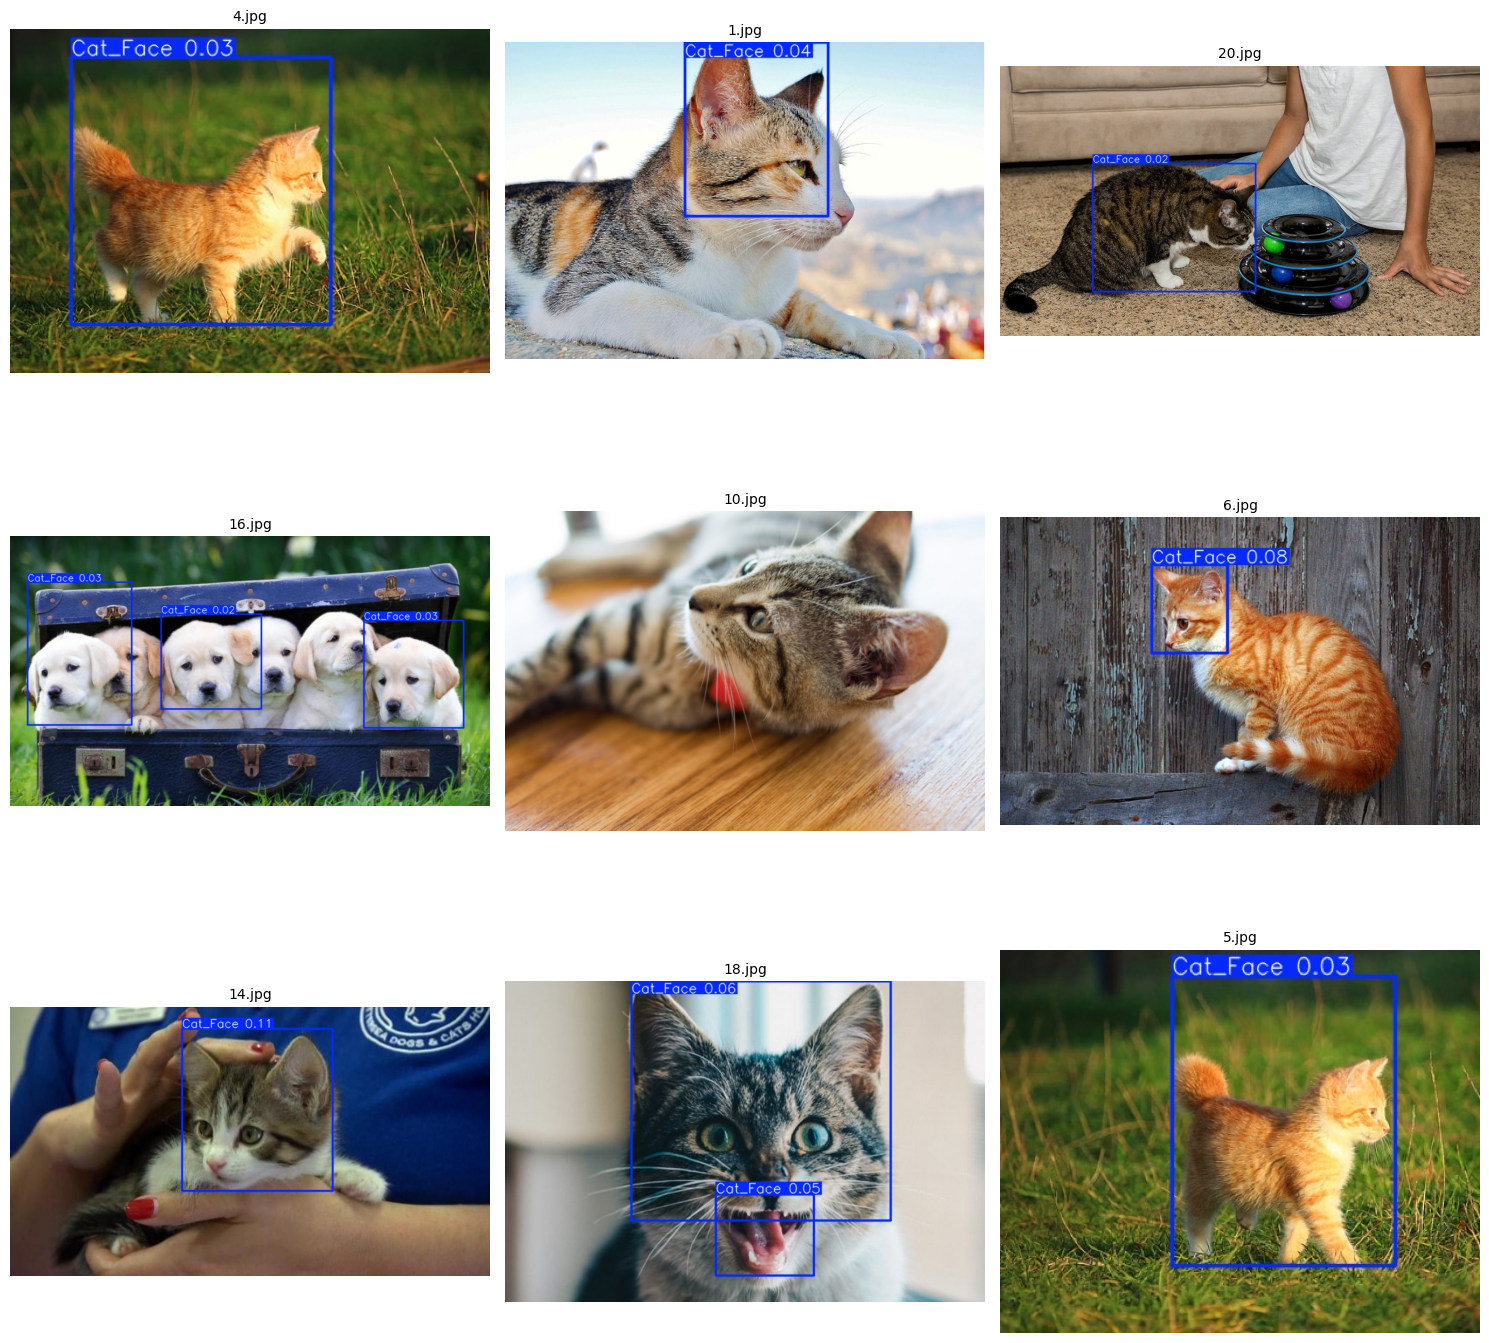


✓ Sample predictions displayed above


In [12]:
# ============================================================================
# STEP 12: Visualize Sample Predictions
# ============================================================================

print("\n" + "="*60)
print("VISUALIZING SAMPLE PREDICTIONS")
print("="*60)

# Find the prediction folder
pred_folders = list(Path('runs/detect').glob('test_predictions*'))
if len(pred_folders) > 0:
    # Use the most recent one
    pred_img_folder = sorted(pred_folders, key=os.path.getmtime)[-1]
    print(f"Using predictions from: {pred_img_folder}")
else:
    pred_img_folder = Path('runs/detect/test_predictions')

pred_images = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    pred_images.extend(list(pred_img_folder.glob(ext)))
pred_images = pred_images[:9]

if len(pred_images) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, img_path in enumerate(pred_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(img_path.name, fontsize=10)

    # Hide empty subplots
    for idx in range(len(pred_images), 9):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions_grid.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Sample predictions displayed above")
else:
    print("No prediction images found")



In [13]:
# ============================================================================
# STEP 13: Model Performance Evaluation
# ============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Validate the model
val_results = trained_model.val()

print(f"\n📊 Performance Metrics:")
print(f"  - mAP50: {val_results.box.map50:.4f}")
print(f"  - mAP50-95: {val_results.box.map:.4f}")
print(f"  - Precision: {val_results.box.mp:.4f}")
print(f"  - Recall: {val_results.box.mr:.4f}")


MODEL PERFORMANCE METRICS
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 197.5±64.0 MB/s, size: 5.1 KB)
val: Scanning /content/cat_face_dataset/labels/val.cache... 20 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 31.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.7it/s 1.2s
                   all         20         27          1       0.35      0.834      0.583
Speed: 12.3ms preprocess, 18.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/runs/detect/val

📊 Performance Metrics:
  - mAP50: 0.8338
  - mAP50-95: 0.5835
  - Precision: 1.0000
  - Recall: 0.3500


In [14]:
# ==========================================================================
# Finally, compressing predicted images with bounding boxes
# ==========================================================================

!zip -r test_predictions.zip /content/runs/detect/test_predictions

  adding: content/runs/detect/test_predictions/ (stored 0%)
  adding: content/runs/detect/test_predictions/4.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/1.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/20.jpg (deflated 3%)
  adding: content/runs/detect/test_predictions/16.jpg (deflated 3%)
  adding: content/runs/detect/test_predictions/10.jpg (deflated 3%)
  adding: content/runs/detect/test_predictions/6.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/14.jpg (deflated 4%)
  adding: content/runs/detect/test_predictions/18.jpg (deflated 4%)
  adding: content/runs/detect/test_predictions/5.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/17.jpg (deflated 2%)
  adding: content/runs/detect/test_predictions/3.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/7.jpg (deflated 0%)
  adding: content/runs/detect/test_predictions/9.jpg (deflated 4%)
  adding: content/runs/detect/test_predictions/11.jpg (deflated

In [15]:
# ============================================================================
# PROJECT SUMMARY
# ============================================================================

print("\n" + "="*60)
print("PROJECT FULL SUMMARY")
print("="*60)

print(f"""

📁 FILES GENERATED:
  1. Output_testing_Images_labels.csv - Your submission file
  2. runs/train/cat_face_detection/ - Training results and plots
  3. runs/detect/test_predictions/ - Annotated test images
  4. sample_predictions_grid.png - Visualization
  5. test_predictions.zip - Predicted images with bounding boxes

📊 KEY RESULTS:
  - Training images: {len(train_images)}
  - Validation images: {len(val_images)}
  - Test images: {len(test_images)}
  - Total predictions: {len(output_df)}
  - Model: YOLOv8n (nano)
  - Training epochs: 50
  - mAP50: {val_results.box.map50:.4f}

💡 INSIGHTS:
  - YOLOv8 provides better accuracy and easier implementation than YOLOv3
  - Transfer learning significantly improves performance on small datasets
  - Proper data preprocessing is crucial for model performance

""")

print("="*60)


PROJECT FULL SUMMARY


📁 FILES GENERATED:
  1. Output_testing_Images_labels.csv - Your submission file
  2. runs/train/cat_face_detection/ - Training results and plots
  3. runs/detect/test_predictions/ - Annotated test images
  4. sample_predictions_grid.png - Visualization
  5. test_predictions.zip - Predicted images with bounding boxes

📊 KEY RESULTS:
  - Training images: 80
  - Validation images: 20
  - Test images: 20
  - Total predictions: 28
  - Model: YOLOv8n (nano)
  - Training epochs: 50
  - mAP50: 0.8338

💡 INSIGHTS:
  - YOLOv8 provides better accuracy and easier implementation than YOLOv3
  - Transfer learning significantly improves performance on small datasets
  - Proper data preprocessing is crucial for model performance


